In [53]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from copy import deepcopy
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from astropy.nddata import StdDevUncertainty
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import tsys_weight,average
from dysh.util import sq_weighted_avg
from dysh.plot.specplot import SpectrumPlot
from astropy.io import fits
from astropy.table import Table
import pandas as pd
pd.set_option('display.max_rows', 100)
from astropy.utils.data import get_pkg_data_filename
#%matplotlib notebook
from numpy.lib.recfunctions import drop_fields
from dysh.util import uniq

-------------

In [2]:
datadir = '/data/gbt'
f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + '/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
#f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
#f = datadir + '/examples/mixed-config/data/TGBT17A_506_11.raw.vegas/TGBT17A_506_11.raw.vegas.A.fits'


In [3]:
sdfits = SDFITSLoad(f,index=False)

In [4]:
sdfits.info()

Filename: /data/gbt/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   6040R x 74C   [32A, 1D, 22A, 1D, 1D, 1D, 32768E, 16A, 6A, 8A, 1D, 1D, 1D, 4A, 1D, 4A, 1D, 1I, 32A, 32A, 1J, 32A, 16A, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 8A, 1D, 1D, 12A, 1I, 1I, 1D, 1D, 1I, 1A, 1I, 1I, 16A, 16A, 1J, 1J, 22A, 1D, 1D, 1I, 1A, 1D, 1E, 1D, 1D, 1D, 1D, 1D, 1A, 1A, 8A, 1E, 1E, 16A, 1I, 1I, 1I]   


In [5]:
sdfits.create_index()

In [6]:
sdfits.rawspectra(0).shape

(6040, 32768)

In [7]:
sdfits._find_bintable_and_row(20)

(0, 20)

In [111]:
sdfits._index["TCAL"]

0       1.428060
1       1.428060
2       1.455164
3       1.455164
4       1.602189
          ...   
6035    1.470465
6036    1.368713
6037    1.368713
6038    1.419782
6039    1.419782
Name: TCAL, Length: 6040, dtype: float32

# 1. GBTFITSLoad and position-switch calibration testing
change to use your specific `datadir`

In [8]:
f = datadir + '/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
p = GBTFITSLoad(f)
p.info()

Filename: /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   18864R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


In [9]:
p.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,60.0,W3_1,-40.0,OnOff,1.0,23.959156,23.694496,6,2,31,1,324.227877,38.679625
1,61.0,W3_1,-40.0,OnOff,2.0,23.959156,23.694496,6,2,31,1,324.152608,38.985757
2,62.0,W3_1,-40.0,Nod,1.0,23.959156,23.694496,6,2,31,1,324.274268,38.393054
3,63.0,W3_1,-40.0,Nod,2.0,23.959156,23.694496,6,2,31,1,324.36716,38.259412
4,64.0,W3_1,-40.0,Track,1.0,23.959156,23.694496,6,2,21,1,324.388427,38.057174
5,65.0,W3_1,-40.0,OnOff,1.0,23.787811,23.694495,5,2,31,1,324.669799,37.080216
6,66.0,W3_1,-40.0,OnOff,2.0,23.787811,23.694495,5,2,31,1,324.574401,37.392527
7,67.0,W3_1,-40.0,Nod,1.0,23.787811,23.694495,5,2,31,1,324.732485,36.800722
8,68.0,W3_1,-40.0,Nod,2.0,23.787811,23.694495,5,2,31,1,324.831544,36.668587
9,69.0,W3_1,-40.0,Track,1.0,23.787811,23.694495,5,2,31,1,324.874404,36.436658


In [10]:
p.summary(verbose=True)

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,PROCSIZE,RESTFREQ,DOPFREQ,IFNUM,FEED,AZIMUTH,ELEVATIO,FDNUM,PLNUM,SIG,CAL,DATE-OBS
0,60,W3_1,-40.0,OnOff,1,2,23.687897,23.694495,1,2,324.213827,38.736915,1,0,T,F,2022-02-17T03:10:09.50
1,60,W3_1,-40.0,OnOff,1,2,23.687897,23.694495,1,2,324.213827,38.736915,1,0,T,T,2022-02-17T03:10:09.50
2,60,W3_1,-40.0,OnOff,1,2,23.687897,23.694495,1,2,324.213827,38.736915,1,1,T,F,2022-02-17T03:10:09.50
3,60,W3_1,-40.0,OnOff,1,2,23.687897,23.694495,1,2,324.213827,38.736915,1,1,T,T,2022-02-17T03:10:09.50
4,60,W3_1,-40.0,OnOff,1,2,23.694495,23.694495,0,2,324.213827,38.736915,1,0,T,F,2022-02-17T03:10:09.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18859,84,W3_4,-48.6,Track,1,1,23.963901,23.694495,4,2,325.065794,33.747309,1,0,F,T,2022-02-17T03:55:03.98
18860,84,W3_4,-48.6,Track,1,1,23.963901,23.694495,4,2,325.065794,33.747309,1,1,T,F,2022-02-17T03:55:03.98
18861,84,W3_4,-48.6,Track,1,1,23.963901,23.694495,4,2,325.065794,33.747309,1,1,T,T,2022-02-17T03:55:03.98
18862,84,W3_4,-48.6,Track,1,1,23.963901,23.694495,4,2,325.065794,33.747309,1,1,F,F,2022-02-17T03:55:03.98


# TPSCAN

In [11]:
tps = p.gettp(scan=60,ifnum=0,plnum=0,fdnum=1,calibrate=True,debug=True)

I  124
P  62
F  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 0


/home/mpound/src/dysh/src/dysh/spectra/core.py:333: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng]) - np.nanmean(caloff[chrng])


62 0


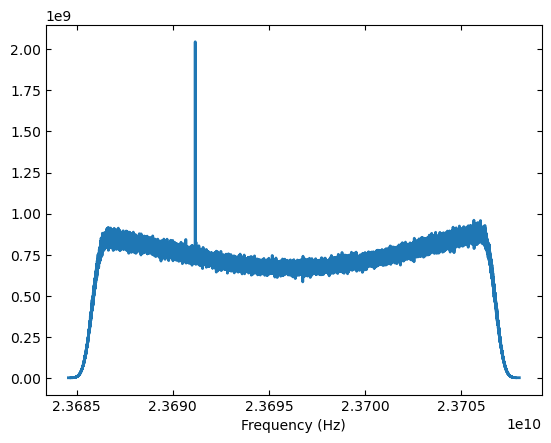

In [12]:
tps[0].total_power(0).plot()

# PSSCAN 


In [13]:
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
p = GBTFITSLoad(f)
psscan = p.getps(scan=152,ifnum=0, plnum=0,calibrate=True)

In [14]:
psscan.calibrate()

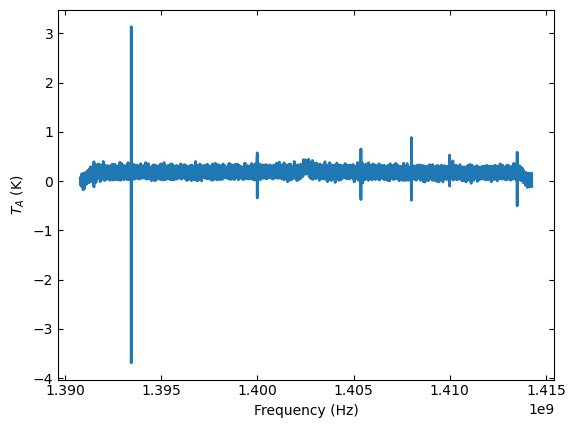

In [15]:
psscan[0].timeaverage().plot()

# get pytest to work

### TPSCAN TEST

In [16]:

import pytest
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename, get_pkg_data_filenames
testdatadir = '/home/mpound/src/dysh/src/dysh/fits/tests/data/'

gbtidl_file = testdatadir +'TGBT21A_501_11_gettp_scan_152_intnum_0_ifnum_0_plnum_0_cal_state_1.fits'
hdu = fits.open(gbtidl_file)
gbtidl_gettp = hdu[1].data["DATA"][0]

sdf_file =testdatadir+'TGBT21A_501_11.raw.vegas.fits'
sdf = GBTFITSLoad(sdf_file,index=True)
tps_on = sdf.gettp(152, sig=True, cal=True, calibrate=False)

In [17]:
diff = tps_on[0].total_power(0).flux.value - gbtidl_gettp
assert(np.nanmean(diff) == 0)

1 0


### PSSCAN TEST

In [18]:
sdf_file = testdatadir+ 'TGBT21A_501_11_ifnum_0_int_0-2.fits'
gbtidl_file = testdatadir + "TGBT21A_501_11_ifnum_0_int_0-2_getps_152_plnum_0.fits"
# Generate the dysh result.
sdf = GBTFITSLoad(sdf_file)
psscan = sdf.getps(152, plnum=0)
psscan.calibrate()
psscan_tavg = psscan.timeaverage(weights="tsys")
assert(len(psscan_tavg) == 1 )

# Load the GBTIDL result.
hdu = fits.open(gbtidl_file)
psscan_gbtidl = hdu[1].data["DATA"][0]

# Compare.

diff = psscan_tavg[0].flux.value - psscan_gbtidl
assert np.nanmedian(diff) == 0.0


In [19]:
psscan[0].calibrated(0)

<Spectrum1D(flux=<Quantity [ 0.09754238, -0.4535061 ,  0.06858956, ...,  0.4810351 ,
           -0.21121033, -0.23867548] K>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0
    doppler_rest=1420405751.7 Hz
    doppler_convention=optical)
  [1.41426369e+09, 1.41426297e+09, 1.41426226e+09, ..., 1.39082833e+09,
   1.39082762e+09, 1.39082690e+09] Hz>)>

In [20]:
def test_compare_with_GBTIDL_tsys_weights():
    testdatadir = '/home/mpound/src/dysh/src/dysh/spectra/tests/data/'
    sdf_file = testdatadir+"TGBT21A_501_11_scan_152_ifnum_0_plnum_0.fits"
    gbtidl_file = testdatadir+"TGBT21A_501_11_gettp_scan_152_ifnum_0_plnum_0_keepints.fits"

    # Generate the dysh result.
    sdf = GBTFITSLoad(sdf_file)
    # tp is a ScanList
    tp = sdf.gettp(152)
    assert len(tp) == 1
    # tpavg is a list
    tpavg = tp.timeaverage()
    assert len(tpavg) == 1

    # Check that we know how to add.
    assert tpavg[0].meta["EXPOSURE"] == tp[0].exposure.sum()

    # Load GBTIDL result.
    hdu = fits.open(gbtidl_file)
    table = hdu[1].data
    data = table["DATA"]
    # Check exposure times.
    assert np.sum(table["EXPOSURE"][:-1] - tp[0].exposure) == 0.0
    assert tpavg[0].meta["EXPOSURE"] == table["EXPOSURE"][-1]
    # System temperature.
    # For some reason, the last integration comes out with a
    # difference in TSYS ~4e-10 rather than ~1e-14. Check why.
    assert np.all(abs(table["TSYS"][:-1] - tp[0].tsys) < 1e-9)
    print(tp[0]._tsys)
    diff = tpavg[0].meta["TSYS"] - table["TSYS"][-1]
    print(f'{tpavg[0].meta["TSYS"]}. {table["TSYS"][-1]}, DIFF = {diff:e}')
    assert abs(tpavg[0].meta["TSYS"] - table["TSYS"][-1]) < 1e-10

    # Data, which uses float -- 32 bits.
    assert np.sum(tp[0]._data - data[:-1]) == 0.0
    assert np.nanmean((tpavg[0].flux.value - data[-1]) / data[-1].mean()) < 2**32


In [21]:
test_compare_with_GBTIDL_tsys_weights()

302 0
[17.45805259 17.4667348  17.51221885 17.47541713 17.2734418  17.23664915
 17.42674356 17.50969685 17.36458617 17.41340567 17.27404002 17.36085608
 17.28454084 17.30618054 17.14631567 16.99965491 17.54035863 17.21348467
 17.39550785 17.3819647  17.48544223 17.42790707 17.15065511 17.20435046
 17.44797715 17.15114567 17.30894525 17.31414487 17.10244044 17.48103422
 17.2923728  17.23753617 17.52469288 17.31082591 17.19219514 17.09618413
 17.34704357 17.13676386 17.38384768 17.48416952 17.22028547 17.50097565
 17.3298689  17.26765102 17.40924103 17.19881801 17.47666079 17.21483006
 17.36518969 17.46643956 17.25166944 17.18425619 17.25067216 17.17091718
 17.13623757 17.36259678 17.24760468 17.27884028 17.25393707 17.19083925
 17.36394916 17.14475973 17.48024845 17.17207775 17.36090444 17.42563372
 17.50779911 17.37681018 17.28915735 17.18587934 17.40009614 17.63290435
 17.35759605 17.26791511 17.19072774 17.44632876 17.39411791 17.47530911
 17.24234982 17.30600229 17.13167095 17.21899

In [22]:
f = datadir + '/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/'
p = GBTFITSLoad(f)
p.info()

doing /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits
doing /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.B.fits
doing /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.C.fits
doing /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.D.fits
doing /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.E.fits
doing /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.F.fits
doing /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.G.fits
Filename: /data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   18864R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '

In [23]:
p._sdf[1].index()

,OBJECT,BANDWID,DATE-OBS,DURATION,EXPOSURE,TSYS,TDIM7,TUNIT7,CTYPE1,CRVAL1,...,TCOLD,CALPOSITION,IFNUM,PLNUM,FDNUM,HDU,BINTABLE,ROW,_OBSTYPE,_SUBOBSMODE
0,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,0,3,1,0,0,PSWITCHON,TPWCAL
1,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,0,3,1,0,1,PSWITCHON,TPWCAL
2,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,3,1,0,2,PSWITCHON,TPWCAL
3,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,3,1,0,3,PSWITCHON,TPWCAL
4,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.369629e+10,...,NaN,Unknown,0,0,3,1,0,4,PSWITCHON,TPWCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18859,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.000000,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396888e+10,...,NaN,Unknown,4,0,3,1,0,18859,FSWITCH,FSW12
18860,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.229289,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396388e+10,...,NaN,Unknown,4,1,3,1,0,18860,FSWITCH,FSW12
18861,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.040545,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396388e+10,...,NaN,Unknown,4,1,3,1,0,18861,FSWITCH,FSW12
18862,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.000000,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396888e+10,...,NaN,Unknown,4,1,3,1,0,18862,FSWITCH,FSW12


In [24]:
p.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,60.0,W3_1,-40.0,OnOff,1.0,23.959156,23.694495,6,2,36,7,324.227878,38.705977
1,61.0,W3_1,-40.0,OnOff,2.0,23.959156,23.694495,6,2,35,7,324.152607,39.012111
2,62.0,W3_1,-40.0,Nod,1.0,23.959156,23.694495,6,2,36,7,324.274257,38.419406
3,63.0,W3_1,-40.0,Nod,2.0,23.959156,23.694495,6,2,35,7,324.367171,38.285767
4,64.0,W3_1,-40.0,Track,1.0,23.959156,23.694496,6,2,24,7,324.388427,38.083529
5,65.0,W3_1,-40.0,OnOff,1.0,23.787811,23.694495,5,2,34,7,324.6698,37.10657
6,66.0,W3_1,-40.0,OnOff,2.0,23.787811,23.694495,5,2,35,7,324.574402,37.418884
7,67.0,W3_1,-40.0,Nod,1.0,23.787811,23.694495,5,2,36,7,324.732475,36.827076
8,68.0,W3_1,-40.0,Nod,2.0,23.787811,23.694495,5,2,35,7,324.831553,36.694947
9,69.0,W3_1,-40.0,Track,1.0,23.787811,23.694496,5,2,33,7,324.874404,36.463014


In [25]:
p._index

,OBJECT,BANDWID,DATE-OBS,DURATION,EXPOSURE,TSYS,TDIM7,TUNIT7,CTYPE1,CRVAL1,...,CALPOSITION,IFNUM,PLNUM,FDNUM,HDU,BINTABLE,ROW,PROC,_OBSTYPE,_SUBOBSMODE
0,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,Unknown,1,0,1,1,0,0,OnOff,PSWITCHON,TPWCAL
1,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,Unknown,1,0,1,1,0,1,OnOff,PSWITCHON,TPWCAL
2,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,Unknown,1,1,1,1,0,2,OnOff,PSWITCHON,TPWCAL
3,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,Unknown,1,1,1,1,0,3,OnOff,PSWITCHON,TPWCAL
4,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.369629e+10,...,Unknown,0,0,1,1,0,4,OnOff,PSWITCHON,TPWCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132043,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.000000,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396888e+10,...,Unknown,4,0,6,1,0,18859,Track,FSWITCH,FSW12
132044,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.229289,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396388e+10,...,Unknown,4,1,6,1,0,18860,Track,FSWITCH,FSW12
132045,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.040545,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396388e+10,...,Unknown,4,1,6,1,0,18861,Track,FSWITCH,FSW12
132046,W3_4,23437500.0,2022-02-17T03:55:03.98,0.497724,0.000000,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.396888e+10,...,Unknown,4,1,6,1,0,18862,Track,FSWITCH,FSW12


In [26]:
scanblock = p.getps(scans=60)

-----------------------------
# Get total power scan integrations and plot the time average 

In [103]:
tps = p.gettp(scan=60,sig=None,cal=None,ifnum=None,plnum=1,fdnum=None,debug="True")
#ta=tps.timeaverage()
#print(len(ta))

P  372
TPROWS len= 372
CALROWS on len= 186
fitsindex= 0
P  372
TPROWS len= 372
CALROWS on len= 186
fitsindex= 1
P  372
TPROWS len= 372
CALROWS on len= 186
fitsindex= 2
P  372
TPROWS len= 372
CALROWS on len= 186
fitsindex= 3
P  372
TPROWS len= 372
CALROWS on len= 186
fitsindex= 4
P  372
TPROWS len= 372
CALROWS on len= 186
fitsindex= 5
P  372
TPROWS len= 372
CALROWS on len= 186
fitsindex= 6


In [105]:
s = tps[2]
df = s._sdfits._index.iloc[s._scanrows]
ifs=uniq(df["IFNUM"])

In [110]:
df[df["IFNUM"].isin([ifs[0]])]

,OBJECT,BANDWID,DATE-OBS,DURATION,EXPOSURE,TSYS,TDIM7,TUNIT7,CTYPE1,CRVAL1,...,TCOLD,CALPOSITION,IFNUM,PLNUM,FDNUM,HDU,BINTABLE,ROW,_OBSTYPE,_SUBOBSMODE
2,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,2,PSWITCHON,TPWCAL
3,W3_1,23437500.0,2022-02-17T03:10:09.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,3,PSWITCHON,TPWCAL
26,W3_1,23437500.0,2022-02-17T03:10:11.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,26,PSWITCHON,TPWCAL
27,W3_1,23437500.0,2022-02-17T03:10:11.50,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,27,PSWITCHON,TPWCAL
50,W3_1,23437500.0,2022-02-17T03:10:13.49,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,50,PSWITCHON,TPWCAL
51,W3_1,23437500.0,2022-02-17T03:10:13.49,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,51,PSWITCHON,TPWCAL
74,W3_1,23437500.0,2022-02-17T03:10:15.49,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,74,PSWITCHON,TPWCAL
75,W3_1,23437500.0,2022-02-17T03:10:15.49,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,75,PSWITCHON,TPWCAL
98,W3_1,23437500.0,2022-02-17T03:10:17.49,0.998244,0.954903,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,98,PSWITCHON,TPWCAL
99,W3_1,23437500.0,2022-02-17T03:10:17.49,0.998244,0.975875,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,2.368970e+10,...,NaN,Unknown,1,1,4,1,0,99,PSWITCHON,TPWCAL


In [44]:
sr = tps[2]._scanrows
tps[2]._sdfits._find_bintable_and_row(sr)[0]

4      0
5      0
6      0
7      0
28     0
      ..
703    0
724    0
725    0
726    0
727    0
Name: BINTABLE, Length: 124, dtype: int64

In [28]:
p.files()

[PosixPath('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'),
 PosixPath('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.B.fits'),
 PosixPath('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.C.fits'),
 PosixPath('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.D.fits'),
 PosixPath('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.E.fits'),
 PosixPath('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.F.fits'),
 PosixPath('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.G.fits')]

In [63]:
sdf = GBTFITSLoad('/data/gbt/examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.D.fits')
sdf.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,60.0,W3_1,-40.0,OnOff,1.0,23.959156,23.694496,6,2,31,1,324.198627,38.719152
1,61.0,W3_1,-40.0,OnOff,2.0,23.959156,23.694496,6,2,31,1,324.123229,39.025289
2,62.0,W3_1,-40.0,Nod,1.0,23.959156,23.694496,6,2,31,1,324.245117,38.432588
3,63.0,W3_1,-40.0,Nod,2.0,23.959156,23.694496,6,2,31,1,324.338095,38.298945
4,64.0,W3_1,-40.0,Track,1.0,23.959156,23.694496,6,2,21,1,324.359427,38.096707
5,65.0,W3_1,-40.0,OnOff,1.0,23.787811,23.694495,5,2,31,1,324.641179,37.119744
6,66.0,W3_1,-40.0,OnOff,2.0,23.787811,23.694495,5,2,31,1,324.545663,37.432063
7,67.0,W3_1,-40.0,Nod,1.0,23.787811,23.694495,5,2,31,1,324.703954,36.840257
8,68.0,W3_1,-40.0,Nod,2.0,23.787811,23.694495,5,2,31,1,324.803091,36.708127
9,69.0,W3_1,-40.0,Track,1.0,23.787811,23.694495,5,2,31,1,324.846022,36.476193


In [68]:
datadir = '/data/gbt'
f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
sdf = GBTFITSLoad(f)

In [81]:
sdf.summary(verbose=True)

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,PROCSIZE,RESTFREQ,DOPFREQ,IFNUM,FEED,AZIMUTH,ELEVATIO,FDNUM,PLNUM,SIG,CAL,DATE-OBS
0,152,NGC2415,3784.0,OnOff,1,2,1.420406,1.420406,0,1,285.951496,42.100624,0,1,T,F,2021-02-10T07:38:37.50
1,152,NGC2415,3784.0,OnOff,1,2,1.420406,1.420406,0,1,285.951496,42.100624,0,1,T,T,2021-02-10T07:38:37.50
2,152,NGC2415,3784.0,OnOff,1,2,1.420406,1.420406,0,1,285.951496,42.100624,0,0,T,F,2021-02-10T07:38:37.50
3,152,NGC2415,3784.0,OnOff,1,2,1.420406,1.420406,0,1,285.951496,42.100624,0,0,T,T,2021-02-10T07:38:37.50
4,152,NGC2415,3784.0,OnOff,1,2,1.612231,1.420406,1,1,285.951496,42.100624,0,1,T,F,2021-02-10T07:38:37.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,153,NGC2415,3784.0,OnOff,2,2,1.667359,1.420406,3,1,287.149353,40.652970,0,0,T,T,2021-02-10T07:48:50.97
6036,153,NGC2415,3784.0,OnOff,2,2,1.720530,1.420406,4,1,287.149353,40.652970,0,1,T,F,2021-02-10T07:48:50.97
6037,153,NGC2415,3784.0,OnOff,2,2,1.720530,1.420406,4,1,287.149353,40.652970,0,1,T,T,2021-02-10T07:48:50.97
6038,153,NGC2415,3784.0,OnOff,2,2,1.720530,1.420406,4,1,287.149353,40.652970,0,0,T,F,2021-02-10T07:48:50.97


In [99]:
tps = sdf.gettp(scan=152,sig=None,cal=None,ifnum=0,plnum=0,fdnum=0,debug="True")
s = tps[0]
df = sdf._index.iloc[s._scanrows]
#print(s._scanrows)
uniq(df["IFNUM"])
#s._scanrows
#sdf._index["SCAN"]

I  604
P  302
F  302
TPROWS len= 302
CALROWS on len= 151
fitsindex= 0


[0]

I  124
P  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 0
I  124
P  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 1
I  124
P  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 2
I  124
P  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 3


/home/mpound/src/dysh/src/dysh/spectra/core.py:333: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng]) - np.nanmean(caloff[chrng])


I  124
P  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 4
I  124
P  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 5
I  124
P  62
TPROWS len= 62
CALROWS on len= 31
fitsindex= 6
S  744
C  372
I  62
P  31
TPROWS len= 31
CALROWS on len= 31
fitsindex= 0
S  744
C  372
I  62
P  31
TPROWS len= 31
CALROWS on len= 31
fitsindex= 1
S  744
C  372
I  62
P  31
TPROWS len= 31
CALROWS on len= 31
fitsindex= 2
S  744
C  372
I  62
P  31
TPROWS len= 31
CALROWS on len= 31
fitsindex= 3
S  744
C  372
I  62
P  31
TPROWS len= 31
CALROWS on len= 31
fitsindex= 4
S  744
C  372
I  62
P  31
TPROWS len= 31
CALROWS on len= 31
fitsindex= 5
S  744
C  372
I  62
P  31
TPROWS len= 31
CALROWS on len= 31
fitsindex= 6
62 0
62 0
62 0
62 0
62 0
62 0
62 0


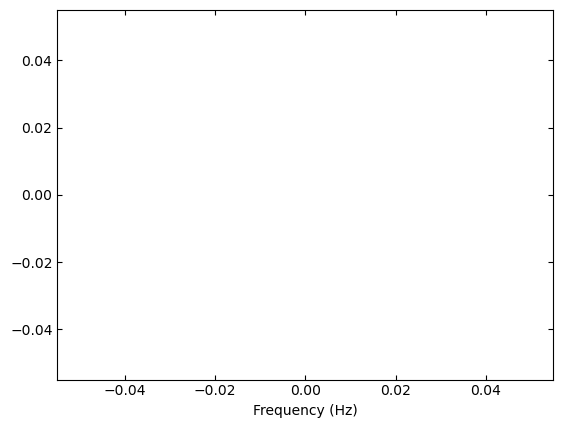

31 0
31 0
31 0
31 0
31 0
31 0
31 0


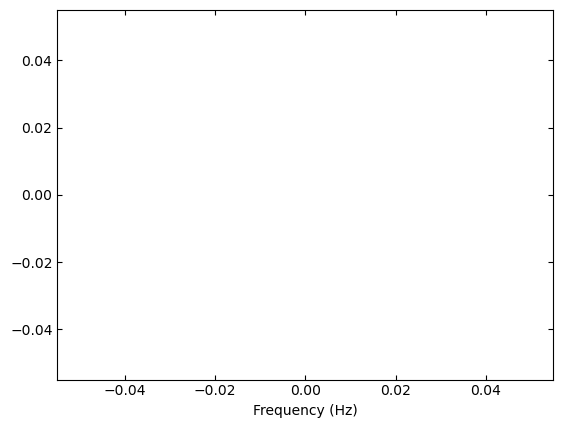

TSYS(cal=T)= nan
TSYS(cal=F)= nan


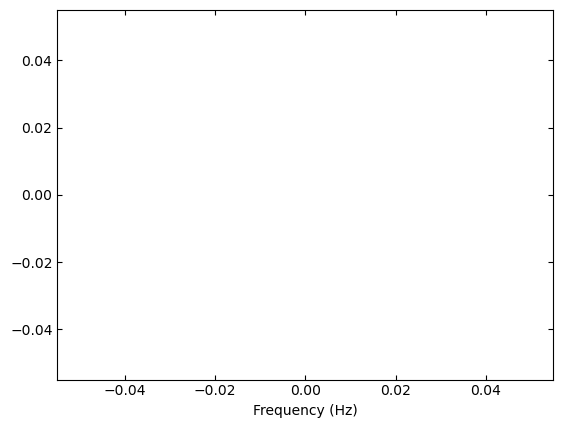

/home/mpound/src/dysh/src/dysh/spectra/core.py:333: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng]) - np.nanmean(caloff[chrng])


31 0
31 0
31 0
31 0
31 0
31 0
31 0


AttributeError: 'list' object has no attribute 'plot'

In [29]:
tps = p.gettp(scan=60,sig=None,cal=None,ifnum=0,plnum=1,debug="True")
tps2 = p.gettp(scan=60,sig=True,cal=False,ifnum=0,plnum=1,debug="True")
s=tps.timeaverage()[0]
s.plot()
so = tps2.timeaverage()[0]
so.plot()
print("TSYS(cal=T)=",s.meta['TSYS'])
print("TSYS(cal=F)=",so.meta['TSYS'])
s2 = (s+so)*0.5
s2.plot()
#(s-so).plot()
tpsc = p.gettp(scan=60,sig=True,cal=True,ifnum=0,plnum=1,calibrate=True)
s4=tpsc.timeaverage()
s4.plot()
s4.data-s.data
print(so.meta["TSYS"])

In [ ]:
tps.timeaverage(weights=None).plot()

In [ ]:
s=tps.timeaverage(weights=None)
s.plot()
s._plotter.figure.savefig("/home/mpound/src/dysh/docs/static/tp_153_eqweight.png")

In [ ]:

print('%s' % (np.array2string(tps.tsys,precision=2)))


In [ ]:
freq,counts=np.loadtxt("../testdata/tp152_if0_pl1_fd0.txt",skiprows=3,unpack=True)
freq=freq*1E9
#fig,ax=plt.subplots()
#ax.plot(freq,counts)
ss = s/2.0
s4.plot()
print(len(counts),len(freq))
freq+=np.mean(s.spectral_axis.value-freq)
s4._plotter.axis.plot(freq,counts,color='r')
freq[0]-freq[1]

## get another TP scan with different IF and Polarization and plot the 13th integration

In [ ]:
tps = p.gettp(scan=153,ifnum=1,plnum=1)
tps.total_power(12).plot()

In [ ]:
tps.timeaverage().plot()

## Try writing scans or records to FITS files and reading them back in


In [ ]:
scanlist = [152]

In [ ]:
p.write_scans("/tmp/scans.fits",overwrite=True,checksum=True,output_verify='fix',scans=scanlist)

In [ ]:
x1 = fits.open("/tmp/scans.fits")
x1.info()

In [ ]:
x1[1].header

In [ ]:
x1 = GBTFITSLoad("/tmp/scans.fits")
#x1._ptable[0]
x1._hdu.info()

In [ ]:
x1._hdu[1].header

In [ ]:
spec4 = p.getspec(4)
sp = SpectrumPlot(spec4)
sp.plot()

## Get a position switch scan and calibrate it.
The default ifnum=0, plnum=0

In [ ]:
# eventually this will have calibrate=True as the default, so you don't need to call calibrate().
psscan = p.getps(152)

In [ ]:
psscan.calibrate()

In [ ]:
xx=psscan.timeaverage()
type(psscan._calibrated)

### the raw calibrated numpy array

In [ ]:
psscan._calibrated

### A single integration of the calibrated Spectrum

In [ ]:
spec1 = psscan.calibrated(3)
sp = SpectrumPlot(spec1)
sp.plot(xaxis_unit="km/s")

### The average spectrum.  
You can plot with equal weights or $T_{sys}$ weighting (the default)
Compare this with GBTIDL `getps, 152`

In [ ]:
t=psscan.timeaverage(weights=None)
t.plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

In [ ]:
t=psscan.timeaverage(weights='tsys').plot()

### Try a different polarization and IF and use the OFF scan number
GBTIDL `getps, 153, ifnum=1, plnum=1`

In [ ]:
psscan = p.getps(152,plnum=1,ifnum=1)
psscan.calibrate()

In [ ]:
psscan.timeaverage().plot()
print(f"T_sys = {np.mean(psscan.tsys)}")

### mixed FS and PS


In [ ]:
if False:
    datadir = '/data/gbt'
    f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
    p = GBTFITSLoad(f)
    p.info()
    p.summary()

--------------------------------

# SubbeamNOD KPFA Data 

In [ ]:
datadir = "/data/gbt/"
f = datadir + 'examples/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/TRCO_230413_Ka.raw.vegas.A.fits'
pnod = GBTFITSLoad(f)
pnod.info()

In [ ]:
pnod.summary()

In [ ]:
df=pnod._ptable[0][pnod._ptable[0]["SCAN"].isin([32])]
len(set(df['DATE-OBS']))

In [ ]:
vegas=np.array([0,32,64,96,128,160,192,224,256,288,320,352,384,416,448,480,544,576,608,640,672,
                704,736,768,800,832,864,896,928,960,992|0,32,64,96,128,160,192,224,256,288,320,
                352,384,416,448,480,544,576,608,640,672,704,736,768,800,832,864,896,928,960,992])

In [ ]:
tsysidl=np.array([84.9435,82.1865,88.1306,79.4702,83.3359,82.1568,
84.8032,87.5031,82.3827,86.6867,81.2290,83.3456,
154.525,76.3337,121.232,107.034,122.812,122.386,
109.684,126.385,106.435,116.182,120.199,117.069,
55.5695,70.8444,84.2473,84.2600,84.1720,85.6708,
83.8575,84.9475,85.0601,83.6906,82.5538,82.3467,
111.679,114.020,115.357,118.397,105.984,115.007,
113.603,113.097,116.426,115.867,114.906,118.247,
65.3346,72.2251,84.1646,83.3890,84.2675,83.7073,
83.2034,84.5122,84.7987,81.9806,83.8689,82.9380,
103.363,111.527,113.147,101.503,108.444,116.663,
111.407,113.278,115.310,115.436,114.451,117.825,
73.3529,71.0150,83.4908,84.2935,82.8866,83.5213,
85.0363,82.4940,82.6460,83.3778,82.8975,82.3562,
90.8207,139.061,101.555,105.921,110.831,112.511,
111.064,117.958,116.047,114.238,121.151,113.204,
74.1397,72.0670,84.6076,84.3983,83.6667,84.0574,
82.1753,81.9777,82.7533,83.2628,83.1251,84.4301,
72.5894,138.020,105.265,103.819,112.595,115.162,
116.772,115.474,114.101,114.157,115.170,112.846,
])
#len(tsysidl)     120                                                                                                             
      

In [ ]:
subrefdata=[0,0]
subreffreq=[0,0]

In [ ]:
f,d = np.loadtxt("/home/mpound/subref-1.ascii",skiprows=3,unpack=True)
subreffreq[0] =f
subrefdata[0] =d

In [ ]:
f,d = np.loadtxt("/home/mpound/subref+1.ascii",skiprows=3,unpack=True)
subreffreq[1] =f
subrefdata[1] =d

In [ ]:
snodka_43 = np.loadtxt("/home/mpound/snod43_if0_fd1_pl0.ascii",skiprows=3,unpack=True)

In [ ]:
92*6198*(subrefdata[1]-subrefdata[0])/subrefdata[0]

In [ ]:
ifnum=0
plnum=0
fdnum=1
scan=43
bintable=0
weights='tsys'
cal=None

In [ ]:

tp1=pnod.gettp(scan,cal=cal,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,calibrate=True,subref=-1)
np.mean(np.abs(tp1.tsys))
#np.mean(tp1.tsys,where=((tp1.tsys>0) and (tp1.tsys<100)))
#w=np.where((tp1.tsys>0) &(tp1.tsys<100))[0]
#np.mean(tp1.tsys)
#np.shape(tp1.data)

In [ ]:
tpa=tp1.timeaverage()
tpa.plot()
tpa.meta['TSYS']

In [ ]:
subref=-1
print(tp1.timeaverage().meta["TCAL"])
df=pnod._ptable[0][pnod._ptable[0]["SCAN"].isin([43])]
len(df)
len(df[(df["PLNUM"]==plnum) & (df["FDNUM"] == fdnum) & ( df["SUBREF_STATE"] == subref)])

In [ ]:
#scan=43
tsys = {43:92.6198,46:91.72}
#bintable=0
print(weights)
tpp = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum)
tpon  = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=-1)
tpoff = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=1)
on  =  tpon.timeaverage(weights=weights)
off = tpoff.timeaverage(weights=weights)
if False:
    print(f"ON TCAL: {on.meta['TCAL']} OFF TCAL: {off.meta['TCAL']}")
    print(f"ON TSYS: {on.meta['TSYS']} OFF TSYS: {off.meta['TSYS']}")
    print(f"ON WTTSYS: {on.meta['WTTSYS']} OFF WTTSYS: {off.meta['WTTSYS']}")
    print(f"ON MEANTSYS: {on.meta['MEANTSYS']} OFF MEANTSYS: {off.meta['MEANTSYS']}")
    print("AVEG ",0.5*(on.meta['TSYS']+off.meta['TSYS']))
idl=tsys[scan]*(on-off)/off
#idl = tpp.timeaverage(weights=weights).meta['TSYS']*(on-off)/off
print(tpp.timeaverage(weights=weights).meta['TSYS'])
idl.plot()

In [ ]:
idl.data

In [ ]:
tsys = {43:92.6168,46:91.72}
#bintable=0
print(weights)
tpp = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum)
tpon  = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=-1,calibrate=True)
tpoff = pnod.gettp(scan,sig=None,cal=None,bintable=bintable,fdnum=fdnum,plnum=plnum,ifnum=ifnum,subref=1,calibrate=True)
#on  =  tpon.total_power(0)
#off = tpoff.total_power(0)
tpon.calc_tsys()
print(tpon._tsys_weight)
on = tpon.timeaverage(weights=None)
off = tpoff.timeaverage(weights=None)
if False:
    print(f"ON TCAL: {on.meta['TCAL']} OFF TCAL: {off.meta['TCAL']}")
    print(f"ON TSYS: {on.meta['TSYS']} OFF TSYS: {off.meta['TSYS']}")
    print(f"ON WTTSYS: {on.meta['WTTSYS']} OFF WTTSYS: {off.meta['WTTSYS']}")
    print(f"ON MEANTSYS: {on.meta['MEANTSYS']} OFF MEANTSYS: {off.meta['MEANTSYS']}")
    print("AVEG ",0.5*(on.meta['TSYS']+off.meta['TSYS']))
idl=tsys[scan]*(on-off)/off
#idl = tpp.timeaverage(weights=weights).meta['TSYS']*(on-off)/off
print(tpp.timeaverage(weights=weights).meta['TSYS'])
idl.plot()

In [ ]:
tpoff.timeaverage().meta["TSYS"]

In [ ]:
len(tpon._tsys_weight)

In [ ]:
fn=get_pkg_data_filename("../src/dysh/spectra/tests/data/snodka_43_int_1_fdnum_1_ifnum_0.fits")
hdu=fits.open(fn)
xx = hdu[1].data["DATA"][0]
len(xx)

In [ ]:
sdf=GBTFITSLoad(fn)
sdf.summary()
spec1=sdf.getspec(0)
spec1.plot()
np.mean(spec1.data-idl.data)

In [ ]:
fix,ax=plt.subplots()
ax.plot(spec1.spectral_axis,spec1.data-idl.data)

In [ ]:
tpon.total_power(0).plot()
tpoff.total_power(0).plot()
(0.5*(tpon.total_power(0)+tpoff.total_power(0))).plot()

In [ ]:
print(scan,ifnum,plnum,fdnum,weights)
os = pnod.gettp(scan=scan,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights=None,calbrate=True)
np.mean(np.abs(os.tsys)),os.tsys,len(os.tsys),len(tsysidl)
#os.timeaverage().meta['TSYS']

In [ ]:
print(scan)
se=pnod.subbeamnod(scan=scan,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights=None)
print(se.meta['TSYS'])

In [ ]:
fn=get_pkg_data_filename("../src/dysh/spectra/tests/data/TRCO_230413_Ka_snodka_43_ifnum_0_plnum_0_fdnum_1.fits")
hdu=fits.open(fn)
xx = hdu[1].data["DATA"][0]
len(xx)
np.nanmedian(xx-snodka_43[1])

In [ ]:
fn=get_pkg_data_filename("../src/dysh/spectra/tests/data/test2.fits")
hdu=fits.open(fn)
x = hdu[1].data["DATA"][0]
len(x)

In [ ]:
gbt=GBTFITSLoad(fn)
gbt.summary()
tp=gbt.gettp(43)
spec=gbt.getspec(0)
spec.plot()
se._unit = u.ct

In [ ]:
(se-s).plot()

In [ ]:
s=pnod.subbeamnod(scan=scan,ifnum=ifnum,plnum=plnum,fdnum=fdnum,weights='equal',calibrate=True)
s._unit = u.ct

In [ ]:
s.plot()

In [ ]:
print(np.nanmedian(se.flux.value-x))
se.meta['TSYS']
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,se.flux.value-x)
fig.savefig("diffequal.png")

In [ ]:
se.data,xx

In [ ]:
print(np.nanmedian(s.data-snodka_43[1]))
xx=snodka_43[1]
print(np.nanmedian(s._spectral_axis.to("GHz").value-snodka_43[0]))

In [ ]:
print(np.nanmedian(s.flux.value-xx))
s.meta['TSYS']
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,s.data-xx)
#fig.savefig("difftsyswt.png")

In [ ]:
fig,ax=plt.subplots()
ax.plot(s.spectral_axis,100*(s.flux.value-xx)/xx)
#ax.set_ylim(-0.50,0.5)
ax.set_ylabel("Percent difference")
fig.savefig("subbeammod_tsysweight_diff.png")

In [ ]:
fig,ax=plt.subplots()
ax.plot(se.spectral_axis,100*(se.flux.value-x)/x)
ax.set_ylim(-0.50,0.5)
ax.set_ylabel("Percent difference")
fig.savefig("subbeammod_eqweight_diff.png")

# np.nanmedian(se.flux.value-x)

In [ ]:
se.plot()
#s._plotter.axis.plot(s.spectral_axis,x,color='r')
fix,ax=plt.subplots()
ax.plot(se.spectral_axis,x,color='r')

In [ ]:
print(s.stats())
s.plot()
diff=s/idl
diff.plot()
print(diff.data)
print(diff.stats())
print(s.meta['TSYS']/tsys[scan],s.meta['TSYS']-tsys[scan])

In [ ]:
np.nanmedian(idl.flux.value-x),np.nanmedian(diff.data)

-----
# Debugging from here down.